Importation des librairies

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

import lime
import lime.lime_tabular

import shap

Chargement et pré-traitement des données

In [7]:
# Charger les données
df = pd.read_csv("creditcard_2023.csv")

# Vérifier les valeurs manquantes
print("Valeurs manquantes :\n", df.isnull().sum())

# Remplir les valeurs manquantes (si nécessaire)
df.fillna(0, inplace=True)  # Ou autre stratégie adaptée

# Vérifier si la cible est bien au format binaire
print("Valeurs uniques de la cible :", df["Class"].unique())

# S'assurer que la cible est au format {0,1}
if df["Class"].dtype != np.int64 and df["Class"].dtype != np.float64:
    df["Class"] = LabelEncoder().fit_transform(df["Class"])

# Vérification de la distribution des données
print(df.describe())

# Supprimer la normalisation StandardScaler, car les valeurs sont déjà entre -3 et 3
X = df.drop(columns=["Class"])
y = df["Class"]

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille du dataset après nettoyage :", df.shape)


Valeurs manquantes :
 id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Valeurs uniques de la cible : [0 1]
                  id            V1            V2            V3            V4  \
count  568630.000000  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   284314.500000 -5.638058e-17 -1.319545e-16 -3.518788e-17 -2.879008e-17   
std    164149.486122  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min         0.000000 -3.495584e+00 -4.996657e+01 -3.183760e+00 -4.951222e+00   
25%    142157.250000 -5.652859e-01 -4.866777e-01 -6.492987e-01 -6.560203e-01   
50%    284314.500000 -9.363846e-02 -1.358939e-01  3.528579e-04 -7.376152e-02 

Creation et entrainement du modèle

In [8]:
# Création et entraînement du modèle
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")

c:\Apps\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy : 1.00


Configuration des hyperparamètres

In [9]:
# Définition des hyperparamètres à tester
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8, 1.0], 
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5],
    "reg_lambda": [1.0, 2.0, 5.0]
}


# Grid Search avec validation croisée
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                           param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs paramètres :", best_params)

# Réentraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


c:\Apps\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8}


Calcul du AUC-ROC

AUC-ROC Score : 1.00


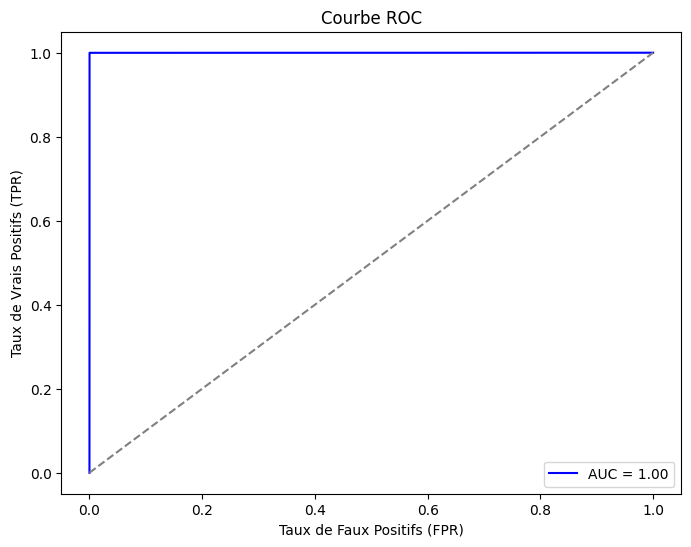

In [10]:
# Prédictions de probabilités avec le meilleur modèle
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calcul de l'AUC-ROC
auc = roc_auc_score(y_test, y_scores)
print(f"AUC-ROC Score : {auc:.2f}")

# Tracé de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.show()

Création Du LIME et SHAP

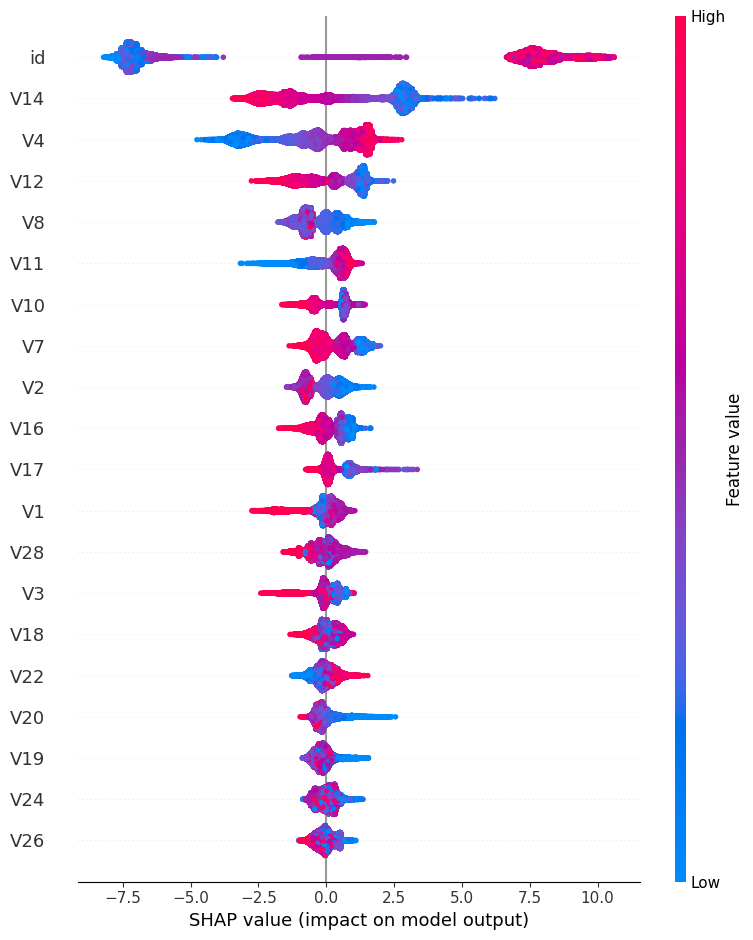

In [11]:
# Ensure X_train and X_test are NumPy arrays
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Création de l'explainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=df.drop(columns=["Class"]).columns,
    class_names=["Classe 0", "Classe 1"],
    mode="classification"
)

# Explication d'une prédiction
idx = 0  # Index d'un échantillon à expliquer
exp = explainer.explain_instance(X_test[idx], best_model.predict_proba, num_features=10)
exp.show_in_notebook()


# Création de l'explainer SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Tracé du résumé SHAP
shap.summary_plot(shap_values, X_test, feature_names=df.drop(columns=["Class"]).columns)